In [ ]:
"""
Instructions on how to run this notebook for demo

1. Download this notebook and move it to google colab
2. Download two images from the repository and upload them to files.
3. Run the notebook


"""

In [1]:
!pip -q install diffusers transformers accelerate torch xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 23.3 MB/s eta 0:00:00


In [2]:
import torch
from PIL import Image
from diffusers import StableDiffusionControlNetImg2ImgPipeline, ControlNetModel, DDIMScheduler
from diffusers.utils import load_image
import base64
from io import BytesIO

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
controlnet = ControlNetModel.from_pretrained(
    "DionTimmer/controlnet_qrcode-control_v11p_sd21",
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/988 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/939 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [4]:
# pipe.enable_xformers_memory_efficient_attention()
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)


In [5]:
pipe.enable_model_cpu_offload()

In [7]:
"""
s
qrcode generator
https://34qr.com/en/#text

"""
def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

def resize_for_condition_image1(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size

    # Choose the target resolution for both width and height
    target_resolution = resolution

    # Calculate the scaling factor based on the target resolution
    k = float(target_resolution) / max(W, H)

    # Scale both width and height by the same factor
    H = int(round(H * k / 64.0)) * 64
    W = int(round(W * k / 64.0)) * 64

    # Resize the image
    img = input_image.resize((W, H), resample=Image.LANCZOS)

    # Crop the image to make it square
    left = (W - target_resolution) // 2
    top = (H - target_resolution) // 2
    right = left + target_resolution
    bottom = top + target_resolution

    img = img.crop((left, top, right, bottom))

    return img

# qr code image
qr_code_image = load_image("/content/demo.png")

qr_code_image1 = resize_for_condition_image(qr_code_image, 768)

# base image
base_image = load_image("/content/base.png")
base_image1 = resize_for_condition_image1(base_image, 768)


print("original qr code size",qr_code_image.size)
print("base image size",base_image.size)
print("afte reshaping")
print(qr_code_image1.size)
print(base_image1.size)

original qr code size (600, 600)
base image size (1386, 1384)
afte reshaping
(768, 768)
(768, 768)


  0%|          | 0/237 [00:00<?, ?it/s]

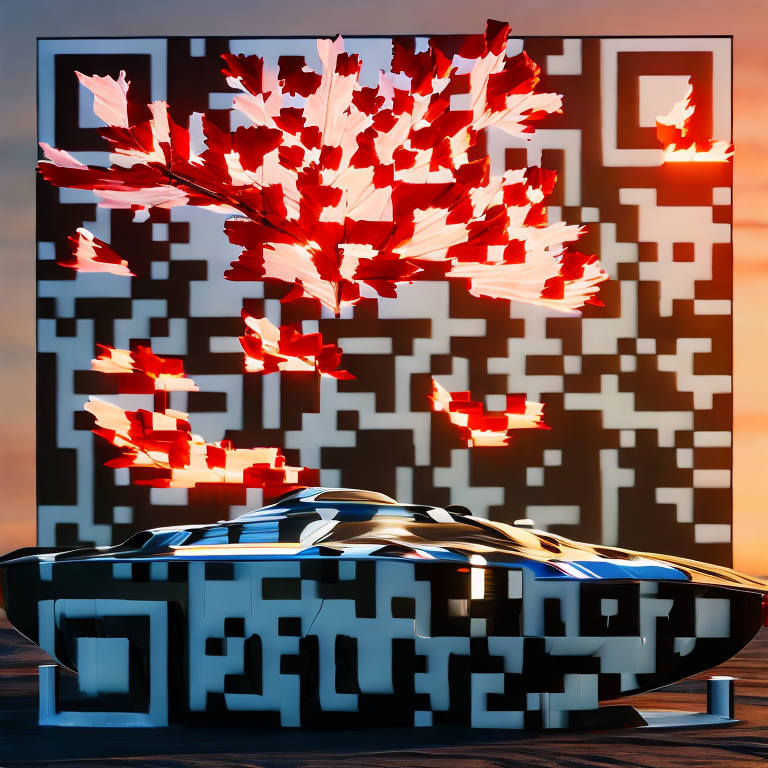

In [8]:


# play with guidance_scale, controlnet_conditioning_scale and strength to vary
# the dominance of the QR Code vs the base image and prompt

# Approximate optimal default value
#   guidance_scale = 20,
#   controlnet_conditioning_scale = 2.0,
#   strength = 0.9

generator = torch.manual_seed(123121231)
image = pipe(
    prompt="realistic, 8K",
    negative_prompt="ugly, disfigured, low quality, blurry, nsfw",
    image=base_image1,
    control_image=qr_code_image1,
    width=768,
    height=768,

    guidance_scale=20, #The higher the values, the sharper the final image is, including the QR Code and base image.
    controlnet_conditioning_scale=1.75, #    #This tweaks how strong to make the QR image vs the base image. The images below you can see the results when varying the value between 0–5. At low values, the QR code does not come through at all. At high values, all you can see is the QR code
    # controlnet_conditioning_scale=4.5,

    generator=generator,
    strength=0.95,
    #this also controls how strong the QR code comes through over the base image.
    #At low values the QR code barely comes though. At high values it is much more dominant
    # num_inference_steps=150
    num_inference_steps=250
)
"""
Increasing the num_inference_steps usually allows for more fine-tuning and refinement of the image by
giving the algorithm more time to adjust and optimize the features based on the specified prompts and parameters.
However, a higher number of steps might also increase the computational time required for generating the image.
"""
image.images[0]